In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

In [2]:
dataset_path = 'human_detection_dataset'
categories = ['0', '1']  
image_size = (128, 128)  


def preprocess_images():
    data = []
    labels = []
    
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        label = int(category)  
        
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                
                img = cv2.imread(img_path)
                img = cv2.resize(img, image_size)
                img = img / 255.0
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {img_name}: {e}")
    
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels


X, y = preprocess_images()

print(f"Processed {len(X)} images.")
print(f"Image shape: {X[0].shape} | Label shape: {y.shape}")


Processed 921 images.
Image shape: (128, 128, 3) | Label shape: (921,)


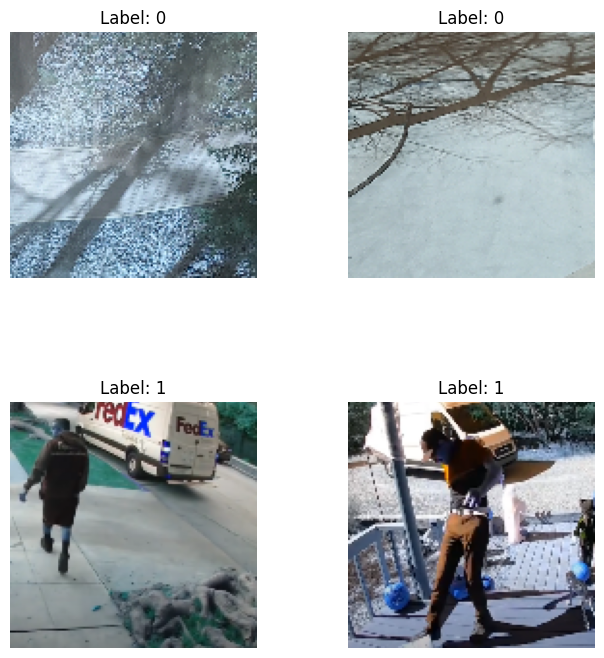

In [3]:
import matplotlib.pyplot as plt

def display_images(X, y):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))  
    fig.subplots_adjust(hspace=0.5)
    images_shown = {0: 0, 1: 0}  
    for i in range(len(X)):
        label = y[i]
        if images_shown[label] < 2:  
            row, col = divmod(images_shown[label] + 2 * label, 2)
            axes[row, col].imshow(X[i])
            axes[row, col].set_title(f"Label: {label}")
            axes[row, col].axis('off')              
            images_shown[label] += 1
        
        if images_shown[0] == 2 and images_shown[1] == 2:  
            break

display_images(X, y)
plt.show()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [6]:
from tensorflow.keras.layers import Dropout

from tensorflow.keras import regularizers

def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())  
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))  

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))  

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model()

C:\Users\ariva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=50, callbacks=[early_stopping, reduce_lr])

C:\Users\ariva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 443ms/step - accuracy: 0.5117 - loss: 2.9646 - val_accuracy: 0.4811 - val_loss: 1.4608 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.5186 - loss: 1.5161 - val_accuracy: 0.4324 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.5583 - loss: 1.2984 - val_accuracy: 0.5676 - val_loss: 1.4290 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.6084 - loss: 1.2705 - val_accuracy: 0.5676 - val_loss: 1.2550 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - accuracy: 0.6264 - loss: 1.2469 - val_accuracy: 0.5676 - val_loss: 1.2427 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.6145 - loss: 1.2077 - val_accuracy: 0.4270 - val_loss: 1.2482 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step - accuracy: 0.6136 - loss: 1.218

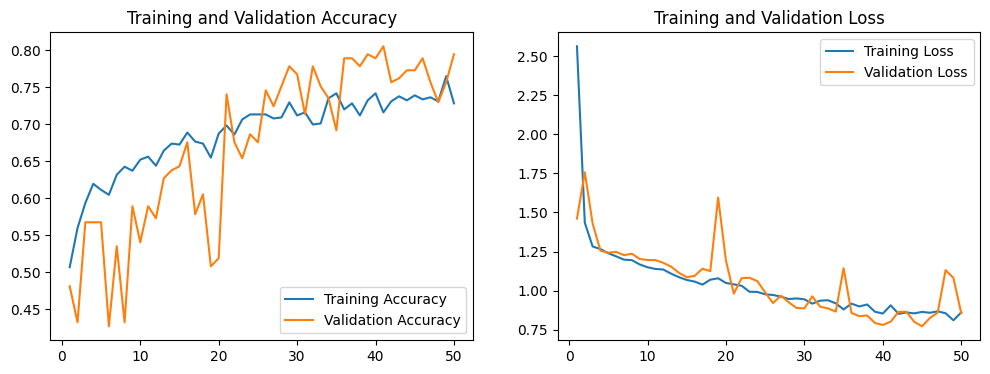

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7990 - loss: 0.7424
Test accuracy: 0.7729730010032654


In [8]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()


plot_training_history(history)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

In [9]:
import os

# Evaluate the model on the test data to get the accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Define the model file name with accuracy included
model_filename = f"cctv_video_optimized_with_accuracy_{test_acc:.4f}.h5"  # Limit accuracy to 4 decimal places

# Save the model
model.save(model_filename)

# Confirm the save
print(f"Model saved as {model_filename}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7990 - loss: 0.7424


Test accuracy: 0.7729730010032654
Model saved as cctv_video_optimized_with_accuracy_0.7730.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Displaying False Positives (True: 0, Pred: 1):


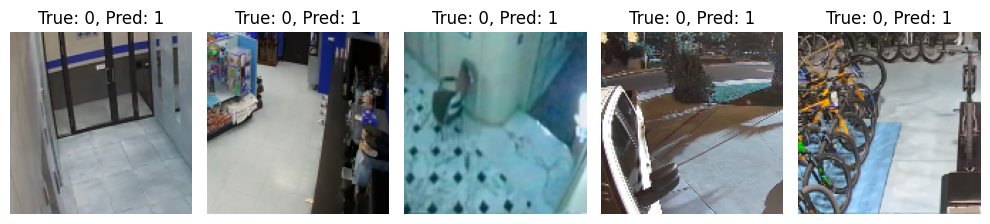

Displaying False Negatives (True: 1, Pred: 0):


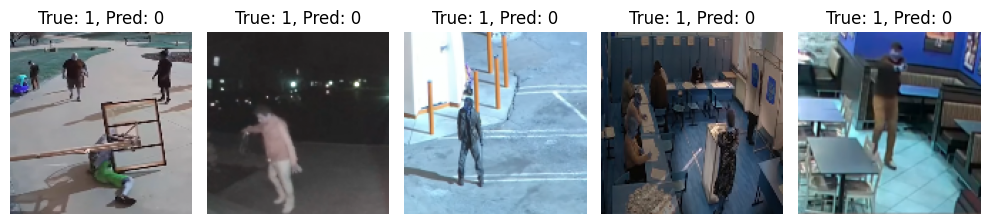

In [10]:

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")  

false_positives = np.where((y_test == 0) & (y_pred.flatten() == 1))[0]

false_negatives = np.where((y_test == 1) & (y_pred.flatten() == 0))[0]

num_false_positives_to_show = min(len(false_positives), 5)
if num_false_positives_to_show > 0:
    print("Displaying False Positives (True: 0, Pred: 1):")
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(false_positives[:num_false_positives_to_show]):
        plt.subplot(1, num_false_positives_to_show, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: 0, Pred: 1")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No False Positives found.")

num_false_negatives_to_show = min(len(false_negatives), 5)
if num_false_negatives_to_show > 0:
    print("Displaying False Negatives (True: 1, Pred: 0):")
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(false_negatives[:num_false_negatives_to_show]):
        plt.subplot(1, num_false_negatives_to_show, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: 1, Pred: 0")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No False Negatives found.")


In [11]:
import numpy as np
import pandas as pd

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
unique, counts = np.unique(y_test, return_counts=True)
label_summary = dict(zip(unique, counts))
print("\nLabel distribution in y_test (0: No Human, 1: Human):")
print(label_summary)

test_summary_df = pd.DataFrame({'True Label': y_test, 'Predicted Label': y_pred.flatten(), 'Prediction Prob': y_pred_probs.flatten()})
print("\nSample test cases (first 5):")
print(test_summary_df.head())


X_test shape: (185, 128, 128, 3)
y_test shape: (185,)

Label distribution in y_test (0: No Human, 1: Human):
{0: 80, 1: 105}

Sample test cases (first 5):
   True Label  Predicted Label  Prediction Prob
0           0                0         0.031719
1           1                1         0.950565
2           1                1         0.636620
3           0                0         0.059975
4           1                1         0.927951


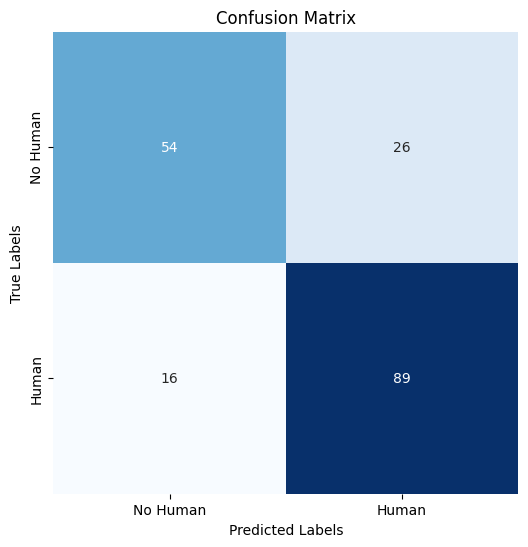

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Human', 'Human'], yticklabels=['No Human', 'Human'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


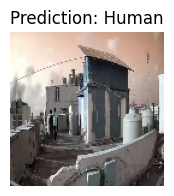

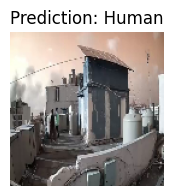

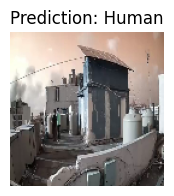

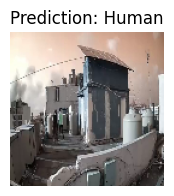

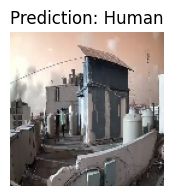

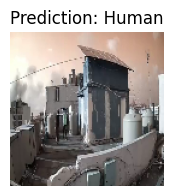

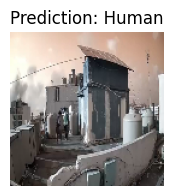

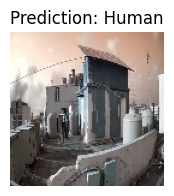

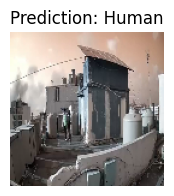

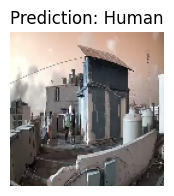

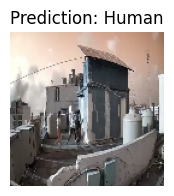

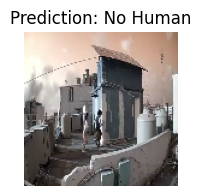

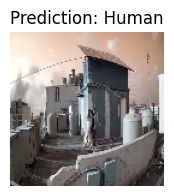

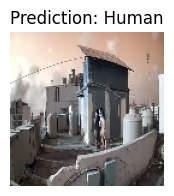

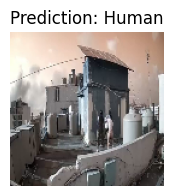

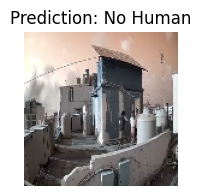

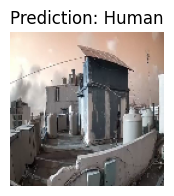

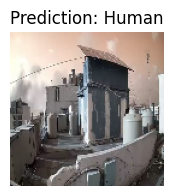

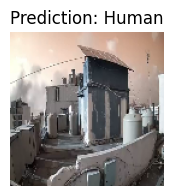

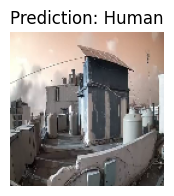

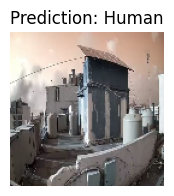

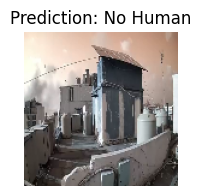

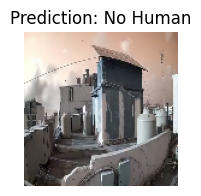

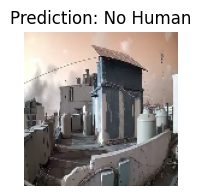

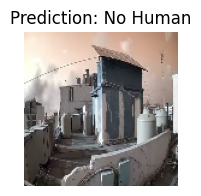

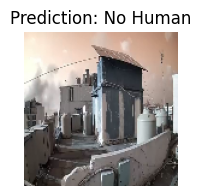

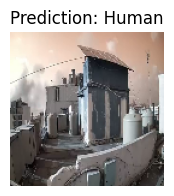

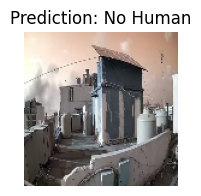

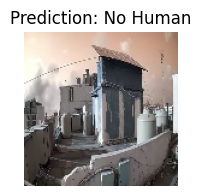

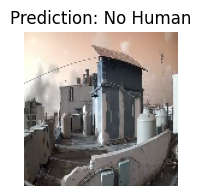

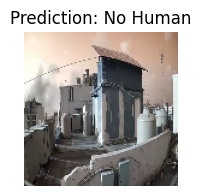

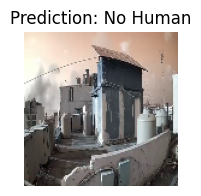

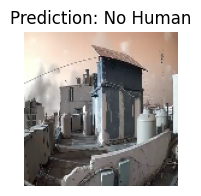

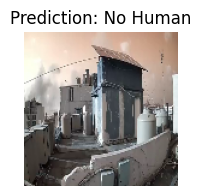

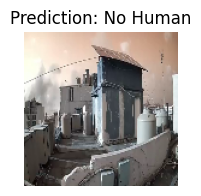

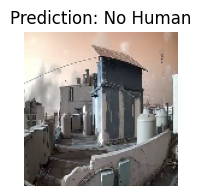

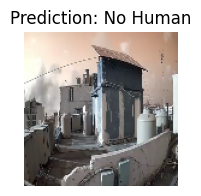

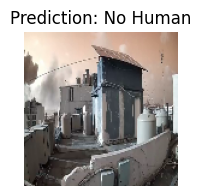

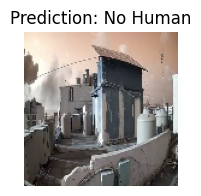

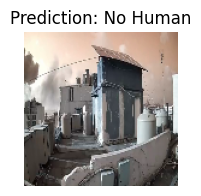

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

video_path = 'E:\cctv_camera\cctv_video_trimmed.mp4'

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Unable to open the video file.")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

num_frames_to_select = 40
frame_interval = total_frames // num_frames_to_select

selected_frames = []

for i in range(num_frames_to_select):
    frame_index = i * frame_interval
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  
    ret, frame = cap.read()
    if ret:
        resized_frame = cv2.resize(frame, (128, 128))
        normalized_frame = resized_frame / 255.0
        selected_frames.append(normalized_frame)
    else:
        print(f"Failed to read frame at index {frame_index}")

cap.release()

selected_frames_np = np.array(selected_frames)

predictions = model.predict(selected_frames_np)

for i, pred in enumerate(predictions):
    plt.figure(figsize=(2, 2))
    plt.imshow(selected_frames_np[i])
    plt.title(f'Prediction: {"Human" if pred > 0.45 else "No Human"}')
    plt.axis('off')
    plt.show()





In [17]:
import numpy as np
import cv2

video_path = 'E:\cctv_camera\cctv_video_trimmed.mp4'
output_path = 'E:\cctv_camera\human_detected_output_new.mp4'  

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Unable to open the video file.")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
output_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_index = 0
human_frames_count = 0  
while True:
    ret, frame = cap.read()
    if not ret:
        break  

    resized_frame = cv2.resize(frame, (128, 128))
    normalized_frame = resized_frame / 255.0
    normalized_frame = np.expand_dims(normalized_frame, axis=0)

    prediction = model.predict(normalized_frame)[0][0]  

    if prediction > 0.45:
        output_video.write(frame)
        human_frames_count += 1

    frame_index += 1
    if frame_index % 100 == 0:
        print(f"Processed {frame_index}/{total_frames} frames.")

cap.release()
output_video.release()

print(f"Video processing complete. {human_frames_count} frames with humans were saved to the output video.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━